# Make a Guess at PACE values

In [1]:
#imports
from importlib import reload

import os
import numpy as np
import xarray

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, time

import pandas
import seaborn as sns

from oceancolor.pace import io as pace_io
from oceancolor.utils import spectra

from cnmf import apply as cnmf_apply

from ihop import io as ihop_io
from ihop.iops import io as iops_io

In [2]:
%matplotlib ipympl

# Load

## PACE

In [3]:
pfile = os.path.join(os.getenv('OS_COLOR'), 'data', 'PACE', 'early',
                     'PACE_OCI.20240413T175656.L2.OC_AOP.V1_0_0.NRT.nc')

In [4]:
reload(pace_io)
xds, flags = pace_io.load_oci_l2(pfile)

In [5]:
xds

<xarray.Dataset> Size: 3GB
Dimensions:     (x: 1710, y: 1272, wl: 184)
Coordinates:
    latitude    (x, y) float32 9MB 30.22 30.23 30.25 30.27 ... 53.44 53.44 53.45
    longitude   (x, y) float32 9MB -93.55 -93.48 -93.41 ... -66.44 -66.33 -66.22
    wavelength  (wl) int32 736B 339 341 344 346 348 351 ... 712 713 714 717 719
Dimensions without coordinates: x, y, wl
Data variables:
    Rrs         (x, y, wl) float32 2GB -3.277e+04 -3.277e+04 ... -3.277e+04
    Rrs_unc     (x, y, wl) float32 2GB -3.277e+04 -3.277e+04 ... -3.277e+04
Attributes: (12/45)
    title:                             OCI Level-2 Data
    product_name:                      PACE_OCI.20240413T175656.L2.OC_AOP.V1_...
    processing_version:                V1.0.0
    history:                           l2gen par=/data5/sdpsoper/vdc/vpu4/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -93.55327
    geospatial_lon_min:                -66.257095
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9942150712013245

### Polish up 

In [6]:
xds['Rrs'] = xarray.where(xds['Rrs']>-10, xds['Rrs'], np.nan)
xds['Rrs'] = xarray.where(xds['Rrs']<100, xds['Rrs'], np.nan)
# Error too
xds['Rrs_unc'] = xarray.where(xds['Rrs']>-10, xds['Rrs_unc'], np.nan)
xds['Rrs_unc'] = xarray.where(xds['Rrs']<100, xds['Rrs_unc'], np.nan)

In [7]:
xds_subset = xds.where((xds.longitude > -78) & (xds.longitude < -73))
xds_subset = xds_subset.where((xds_subset.latitude > 33) & (xds_subset.latitude < 40))

## L23

In [8]:
ab, Chl, Rs, d_a, d_bb = ihop_io.load_l23_full(('nmf','nmf'), (2,2))

Loading... 
Loading decomps from /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_a_N02.npz and /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_bb_N02.npz


## L23 $R_{\rm rs}$ decomposition

In [9]:
decomp_file = iops_io.loisel23_filename('nmf', 'Rrs', 2, 4, 0)
d_Rrs = np.load(decomp_file)
d_Rrs

NpzFile '/home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_Rrs_N02.npz' with keys: M, coeff, spec, mask, err...

# Grab a PACE spectrum

In [10]:
lon = -75.5 # W
lat = 34.5 # N

In [11]:
idx = np.argmin( (xds.longitude.data-lon)**2 + (xds.latitude.data-lat)**2)
idx

53117

In [12]:
x,y = np.unravel_index(idx, xds.longitude.shape)
x,y

(41, 965)

In [13]:
xds.longitude.data[x,y]

-75.49837

In [14]:
spec = xds.Rrs.data[x,y,:]

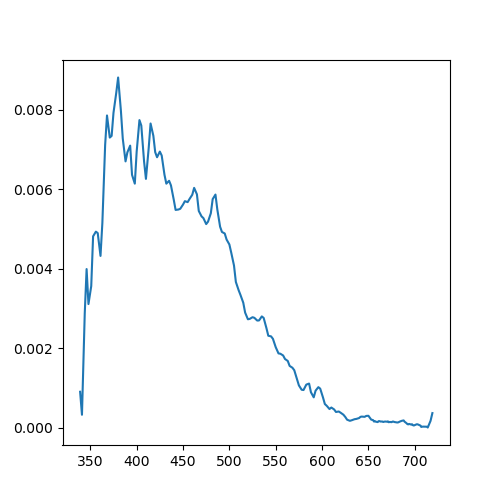

In [15]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
ax.plot(xds.wavelength, spec)
#
plt.show()

# Prep for the rest

In [16]:
spec = np.resize(spec, (1,spec.size))

In [24]:
L23_waves = np.array((d_Rrs['wave']-2.5).tolist() + [d_Rrs['wave'][-1] + 2.5])

In [25]:
rebin_wave, rebin_values, rebin_err = spectra.rebin_to_grid(
    xds.wavelength.data, spec.T, np.ones_like(spec.T), L23_waves)

In [26]:
rebin_wave

array([350., 355., 360., 365., 370., 375., 380., 385., 390., 395., 400.,
       405., 410., 415., 420., 425., 430., 435., 440., 445., 450., 455.,
       460., 465., 470., 475., 480., 485., 490., 495., 500., 505., 510.,
       515., 520., 525., 530., 535., 540., 545., 550., 555., 560., 565.,
       570., 575., 580., 585., 590., 595., 600., 605., 610., 615., 620.,
       625., 630., 635., 640., 645., 650., 655., 660., 665., 670., 675.,
       680., 685., 690., 695., 700., 705., 710., 715., 720., 725., 730.,
       735., 740., 745., 750.])

## Check

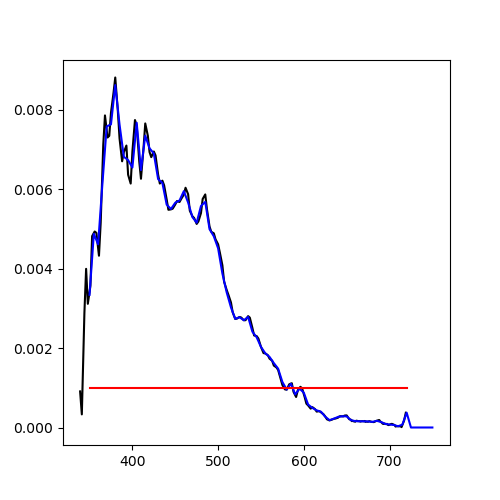

In [28]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
ax.plot(xds.wavelength, spec[0], 'k-', label='Orig')
ax.plot(rebin_wave, rebin_values[0,:], 'b-', label='Rebin')
ax.plot(rebin_wave, rebin_err[0,:]*1e-3, 'r', label='Error')
#
plt.show()

## Errors

In [30]:
ok_wv = (rebin_wave > 380.) & (rebin_wave < 700.)
rebin_err[0,:] = 1.
rebin_err[0,ok_wv] = 2.e-4

# Fit with NMF

In [31]:
Rrs_scale = 1e4

In [40]:
# No scale
nmf_coeff = cnmf_apply.calc_coeff(d_Rrs['M'], rebin_values, 1./(rebin_err)**2)

Working on component:  1
Current Chi2=41.7280, Previous Chi2=1327.1363, Change=96.8558% @ niters=0
Took 0.000 minutes to reach current solution.
Working on component:  2
Current Chi2=5.4663, Previous Chi2=553.3369, Change=99.0121% @ niters=0
Current Chi2=1.2096, Previous Chi2=1.2103, Change=0.0567% @ niters=20
Took 0.000 minutes to reach current solution.


In [41]:
nmf_coeff[:,0]

array([0.12631116, 0.11278949])

## Check

In [42]:
recon = np.dot(nmf_coeff[:,0], d_Rrs['M'])
recon.size

81

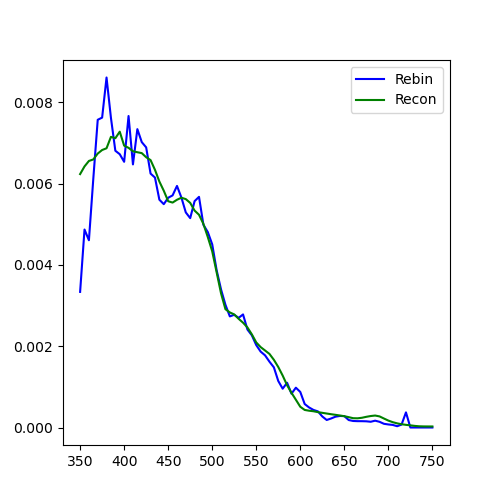

In [43]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
ax.plot(rebin_wave, rebin_values[0,:], 'b-', label='Rebin')
ax.plot(rebin_wave, recon, 'g-', label='Recon')
ax.legend()
#
plt.show()

# Find closest match in L23

In [45]:
d_Rrs['coeff'].shape

(3320, 2)

In [46]:
idx = np.argmin( (d_Rrs['coeff'][:,0] - nmf_coeff[0,0])**2 + 
    (d_Rrs['coeff'][:,1] - nmf_coeff[1,0])**2)
idx

2473

In [47]:
nmf_coeff[:,0], d_Rrs['coeff'][idx]

(array([0.12631116, 0.11278949]), array([0.12523689, 0.11287818]))

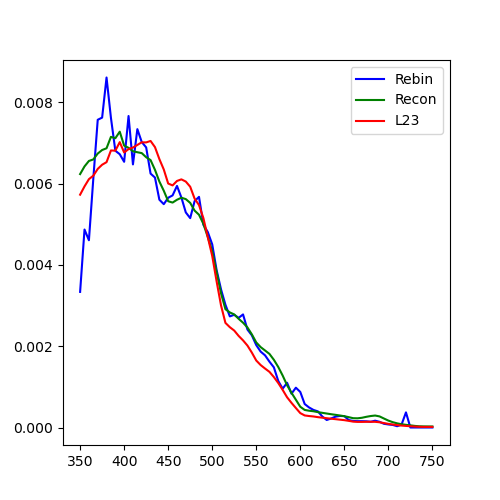

In [48]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
ax.plot(rebin_wave, rebin_values[0,:], 'b-', label='Rebin')
ax.plot(rebin_wave, recon, 'g-', label='Recon')
ax.plot(d_Rrs['wave'], d_Rrs['spec'][idx], 'r-', label='L23')
ax.legend()
#
plt.show()

----

In [49]:
spec.shape

(1, 184)

In [ ]:
xds.Rrs.data.shape

In [55]:
xds.Rrs.data.shape

(2175120, 184)

In [54]:
nx, ny = xds.Rrs.data.shape[0], xds.Rrs.data.shape[1]
Rrs = np.resize(xds.Rrs.data, (nx*ny, xds.Rrs.data.shape[2]))
Rrs.shape

IndexError: tuple index out of range

In [ ]:
rebin_wave, rebin_values, rebin_err = spectra.rebin_to_grid(
    xds.wavelength.data, spec.T, np.ones_like(spec.T), L23_waves)